# 5 - Working With Feature Geometries

GPlately can be used to read, process and plot geological features contained in ESRI Shapefiles (with file extension .shp) and GPML files (with file extension .gpml or .gpmlz). In this notebook, we will look at:

- Plotting shapely geometries using GPlately's `PlotTopologies` object
- Plotting extra .gpml features such as:
    - Polylines
    - Polygons
    - Points

_(These GPML files are sourced from EarthByte's GPlates 2.3 Dataset library: https://www.earthbyte.org/gplates-2-3-software-and-data-sets/  and loaded in with GPlately's `DataServer` object.)_

Let's set up all our packages:

In [1]:
import gplately

import numpy as np
import gplately.pygplates as pygplates
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

GPlately's `PlotTopologies` object uses the `PlateReconstruction` object to reconstruct geological features. It then turns the reconstructed features into Shapely MultiPolygon, MultiPoint and/or MultiLine geometries and plots them onto GeoAxis maps. To call `PlotTopologies`, we need to pass:

- the `PlateReconstruction` plate motion model we just created
- a specific reconstruction time (Ma),
- a coastline filename or `<pygplates.FeatureCollection>` object,
- a continent filename or `<pygplates.FeatureCollection>` object,
- and a continent-ocean boundary (COBs) filename or `<pygplates.FeatureCollection>` object,

We'll first construct the `PlateReconstruction` object, which needs a `rotation model`, a `topology_feature` collection and `static_polygons`. Let's use GPlately's `DataServer` to download these files from Müller et al. (2019) (https://www.earthbyte.org/muller-et-al-2019-deforming-plate-reconstruction-and-seafloor-age-grids-tectonics/).

In [2]:
# Initialise gplately data server and extract data from Muller et al. 2019
gdownload = gplately.download.DataServer("Muller2019")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Create the plate motion model!
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


We can also download the `coastlines`, `continents` and `COBs` needed for our `PlotTopologies` object using `DataServer`.

In [3]:
# Obtain Muller et al. 2019 geometries with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object 
gplot = gplately.PlotTopologies(model, coastlines=coastlines, continents=continents, COBs=COBs)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


## Plotting shapely geometries using GPlately's PlotTopologies object

We can use `get_feature_data` on GPlately's `DataServer` object to download assorted feature data to reconstruct through geological time.

### Plotting Shapely Polylines

Let's visualise a set of polylines from Matthews et al. 2011** that define the tectonic fabric of global seafloors at present day digitised from vertical gravity gradient (VGG) maps. These polylines represent global fracture zones (FZs), v-shaped structures (VANOMs), discordant zones (DZs), fracture zones (hand-traced with less certainty) (FZLCs), unclassified V-anomalies (UNCVs) and extinct ridges. 

Let's load these features in with GPlately's `DataServer`.

**_(Matthews, K. J., Müller, R. D., Wessel, P., Whittaker, J. M. 2011. The tectonic fabric of the ocean basins, The Journal of Geophysical Research. Doi: 10.1029/2011JB008413.)_ 

In [4]:
# Set present day
time = 0 # Ma
seafloor_fabric = gdownload.get_feature_data("SeafloorFabric")

Checking whether the requested files need to be updated...
Requested files are up-to-date!


`DataServer` returned the seafloor fabric as a list of pygplates feature collections, one for each type of fabric. To reconstruct and plot them, we loop through each Feature and:

- Reconstruct them using the `PlateReconstruction` object
- Turn the reconstructed feature into a set of Shapely polylines using the `shapelify_feature_lines` method in the GPlately `plot` module. 

We want to identify each feature by colour, so these steps are done in a for loop. Each seafloor feature is plotted onto a Cartopy GeoAxis map.

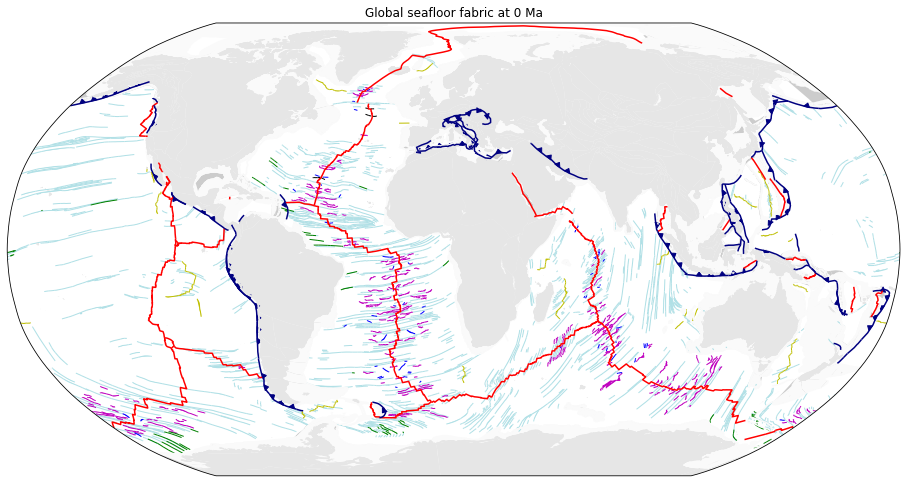

In [5]:
# Set up GeoAxis and plot shapefile topologies
ax2 = plt.figure(figsize=(16,12)).add_subplot(111, projection=ccrs.Robinson(central_longitude=10))
gplot.time = time
gplot.plot_continents(ax2, facecolor='0.8')
gplot.plot_continent_ocean_boundaries(ax2, color='0.98')
gplot.plot_coastlines(ax2, color='0.9')
gplot.plot_ridges_and_transforms(ax2, color='r')
gplot.plot_trenches(ax2, color='navy')
gplot.plot_subduction_teeth(ax2, color='navy')
plt.title('Global seafloor fabric at %i Ma' % (time))

# Seafloor fabric topology identification variables
colours = ['powderblue', 'k', 'm', 'g', 'b', 'y']

# Loop through all seafloor fabric filenames, reconstruct each topology and plot onto ax2 using GPlately
for i, fabric in enumerate(seafloor_fabric):
    reconstructed_seafloor_topology = model.reconstruct(fabric, time)
    polylines = gplately.plot.shapelify_feature_lines(reconstructed_seafloor_topology)
    ax2.add_geometries(polylines, crs=ccrs.PlateCarree(), facecolor=colours[i], edgecolor=colours[i])
    

If you have moviepy available, you can create a gif that illustrates the generation of tectonic seafloor fabric over many Ma. Let's reconstruct plate movements over 150 Ma in intervals of 10 Ma.

In [6]:
# Seafloor fabric topology identification variables
colours = ['powderblue', 'k', 'm', 'g', 'b', 'y']
feat = ['Fracture Zones', 'V-Shaped Structures', 'Discordant Zones', 'Fracture Zones (less certainty)', 
        'Unclassified V-Anomalies', 'Extinct Ridges']

# Time variables
oldest_seed_time = 150 # Ma
time_step = 10 # Ma

# Create a plot for each 10 Ma interval
for time in np.arange(oldest_seed_time,0.,-time_step):
    
    # Set up GeoAxis and plot shapefile topologies
    ax5 = plt.figure(figsize=(16,12), dpi=200).add_subplot(111, projection=ccrs.Robinson(central_longitude=10))
    gplot.time = time
    gplot.plot_continents(ax5, facecolor='0.8')
    gplot.plot_continent_ocean_boundaries(ax5, color='0.98')
    gplot.plot_coastlines(ax5, color='0.9')
    gplot.plot_ridges_and_transforms(ax5, color='r')
    gplot.plot_trenches(ax5, color='navy')
    gplot.plot_subduction_teeth(ax5, color='navy')
    plt.title('Global seafloor fabric at %i Ma' % (time))
    
    # Loop through all seafloor fabric filenames, reconstruct each topology and plot onto ax2 using GPlately
    for i, fabric in enumerate(seafloor_fabric):
        reconstructed_seafloor_topology = model.reconstruct(fabric, time)
        polylines = gplately.plot.shapelify_feature_lines(reconstructed_seafloor_topology)
        ax5.add_geometries(polylines, crs=ccrs.PlateCarree(), facecolor=colours[i], edgecolor=colours[i])
        ax5.set_global()
        
    plt.savefig('/tmp/seafloor_fabric_%d_Ma.png' % time)
    plt.close()
    print('Image for %d Ma saved' % time)
    

Image for 150 Ma saved
Image for 140 Ma saved
Image for 130 Ma saved
Image for 120 Ma saved
Image for 110 Ma saved
Image for 100 Ma saved
Image for 90 Ma saved
Image for 80 Ma saved
Image for 70 Ma saved
Image for 60 Ma saved
Image for 50 Ma saved
Image for 40 Ma saved
Image for 30 Ma saved
Image for 20 Ma saved
Image for 10 Ma saved


MoviePy - Building file /tmp/seafloor_fabric_movie.gif with imageio.


The movie will show up in a few seconds. Please be patient...


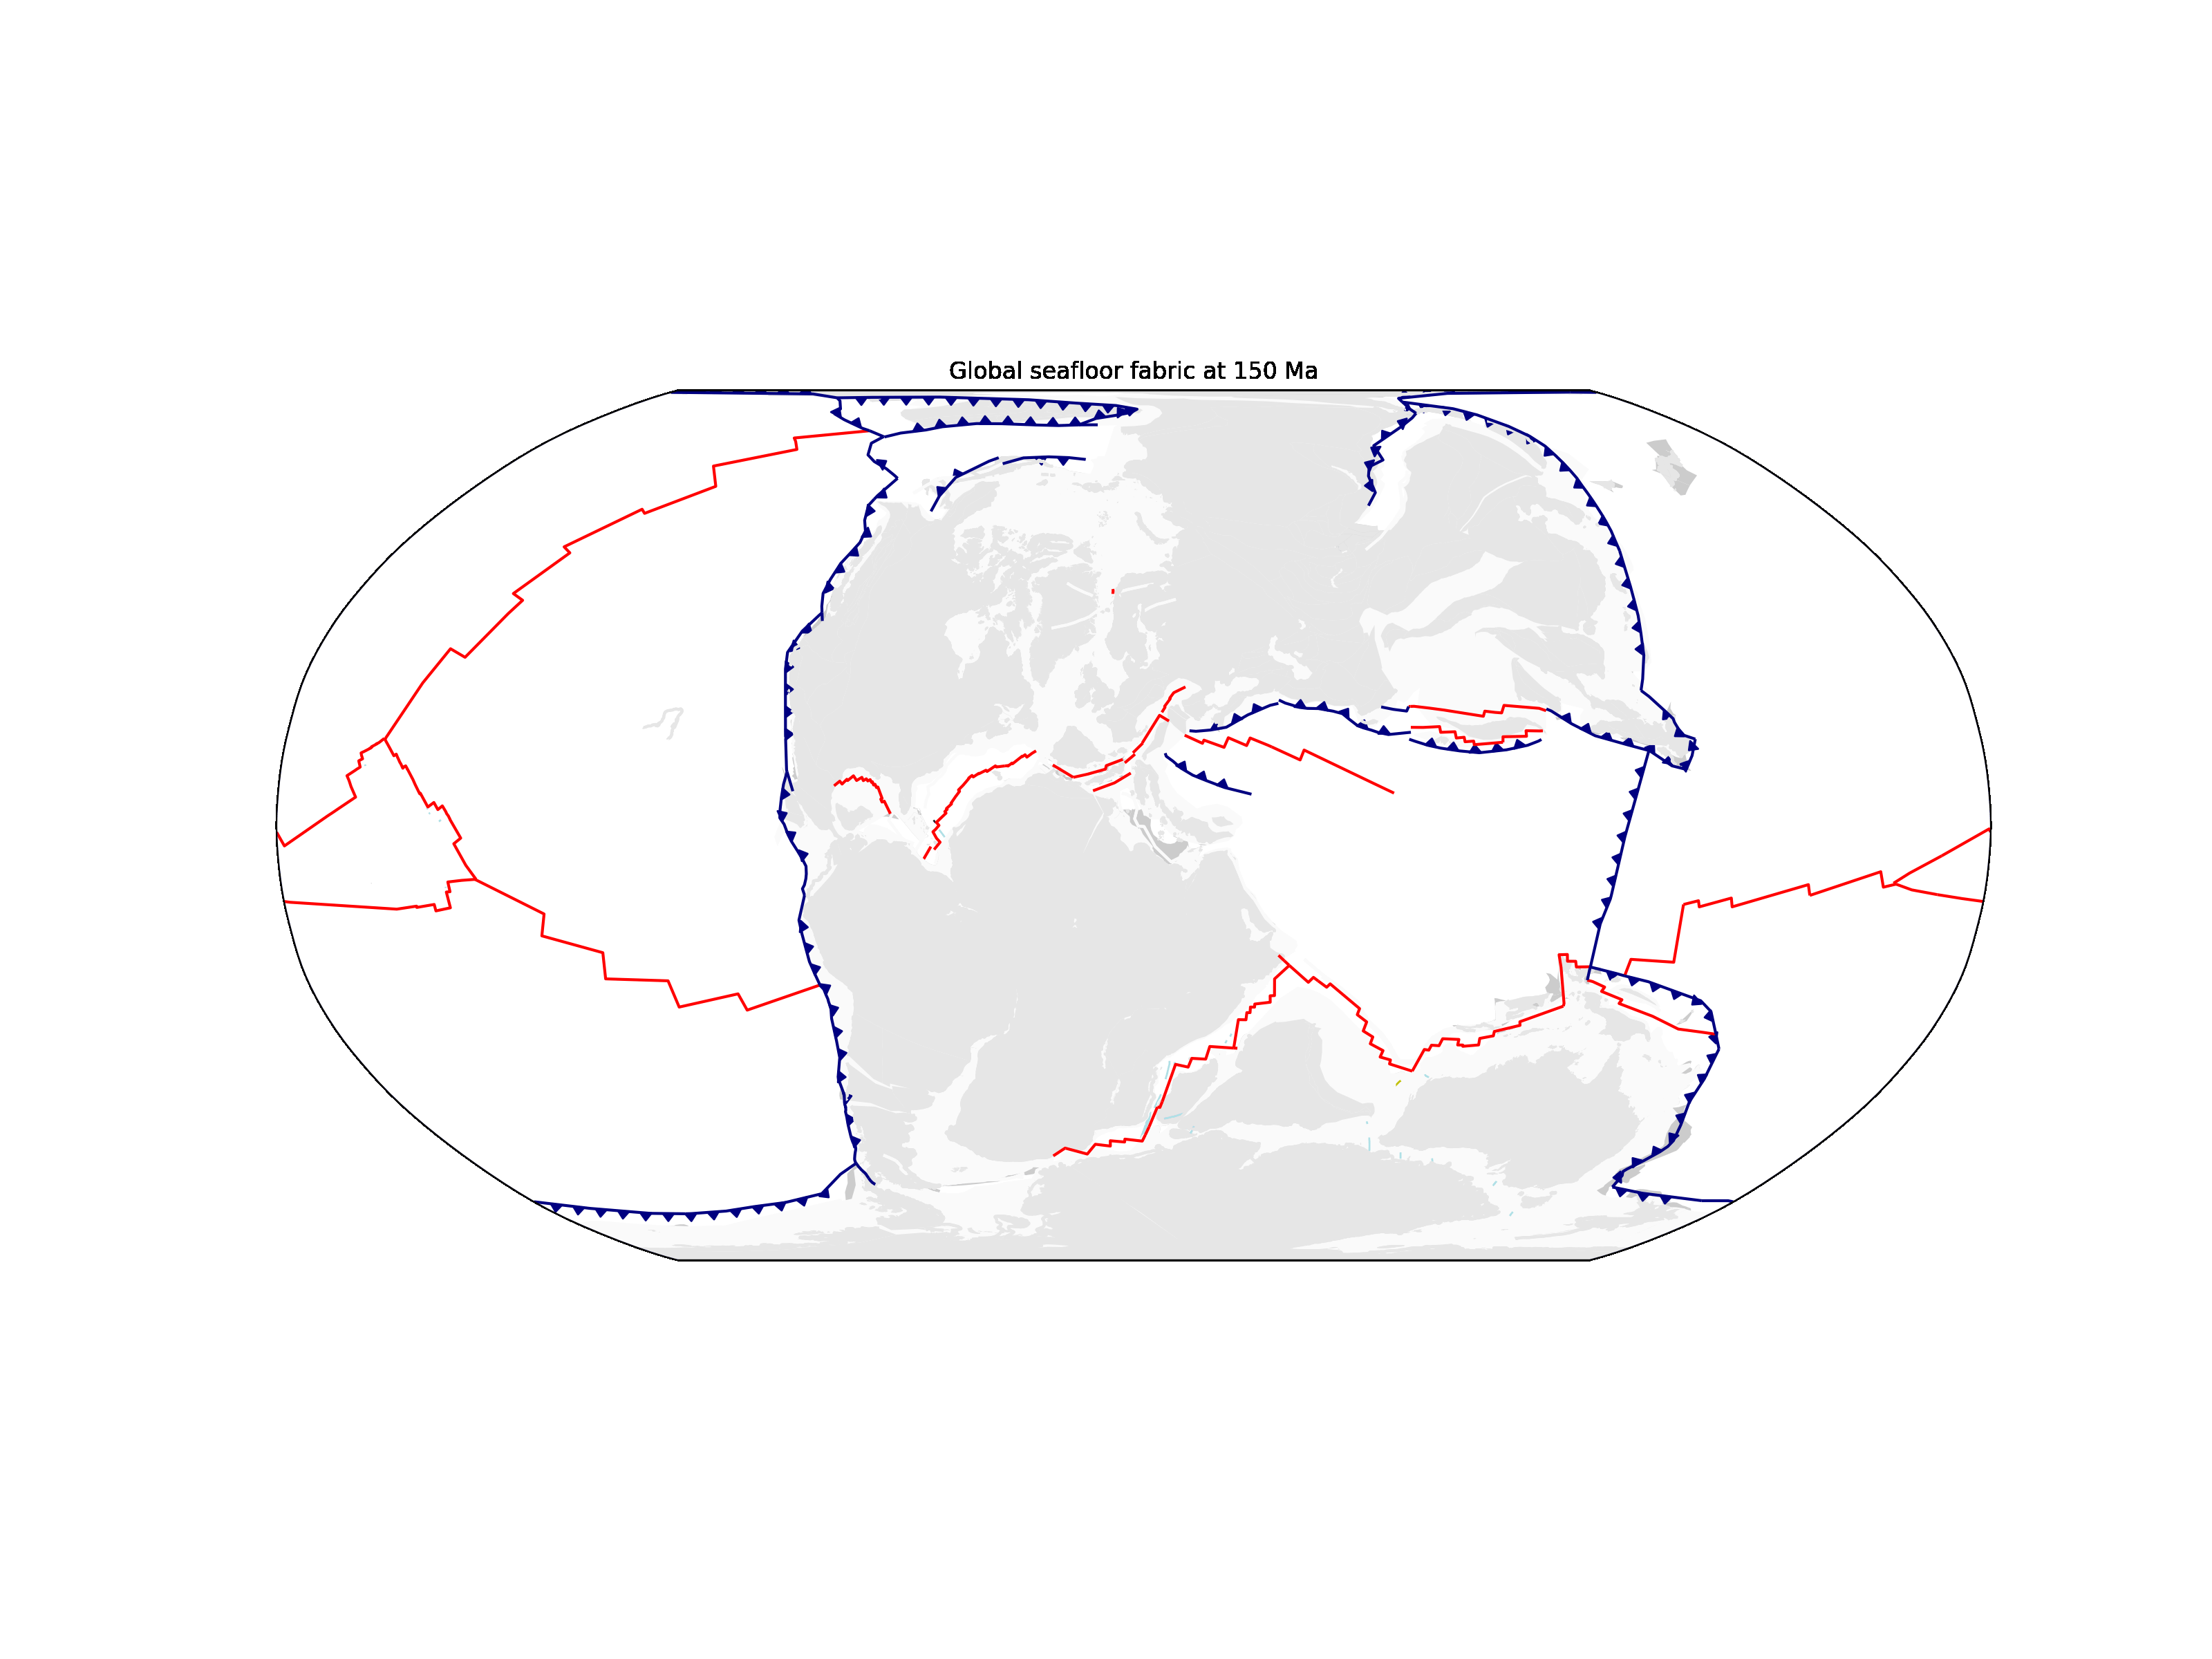

In [7]:
import moviepy.editor as mpy

frame_list = []

for time in np.arange(oldest_seed_time,0.,-time_step):
    frame_list.append('/tmp/seafloor_fabric_%d_Ma.png' % time)

clip = mpy.ImageSequenceClip(frame_list, fps=5)
clip.write_gif('/tmp/seafloor_fabric_movie.gif')

from IPython.display import Image
print('The movie will show up in a few seconds. Please be patient...')
with open('/tmp/seafloor_fabric_movie.gif','rb') as f:
    display(Image(data=f.read(), format='png', width = 3000, height = 1000))

### Plotting Shapely Polygons

Let's visualise two polygon-feature data sets:

1) Global __volcanic provinces__ at present day from "The interplay between the eruption and weathering of Large Igneous Provinces and the deep-time carbon cycle" by Johansson et al. (2018)

2) Global __large igneous provinces (LIPs)__ from the "Long-term interaction between mid-ocean ridges and mantle plumes" by Whittaker et al. (2015).

We'll obtain these files using GPlately's `DataServer` object:

In [8]:
# Locate the Johansson et al. (2018) and Whittaker et al. (2015) gpmlz files containing volcanic provinces & LIPs
lip_volcanic_provinces = [gdownload.get_feature_data("Johansson2018"),
                          gdownload.get_feature_data("Whittaker2015")]

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!


We now have a list containing the LIP and Volcanic Province topology files. Let's use a `for` loop to loop through each `<pygplates.FeatureCollection>` object in the list and:

- Reconstruct topologies to a specific geological time,
- Turn topologies into shapely polygons
- Add shapely geometries onto a GeoAxis map with formatting keyword arguments

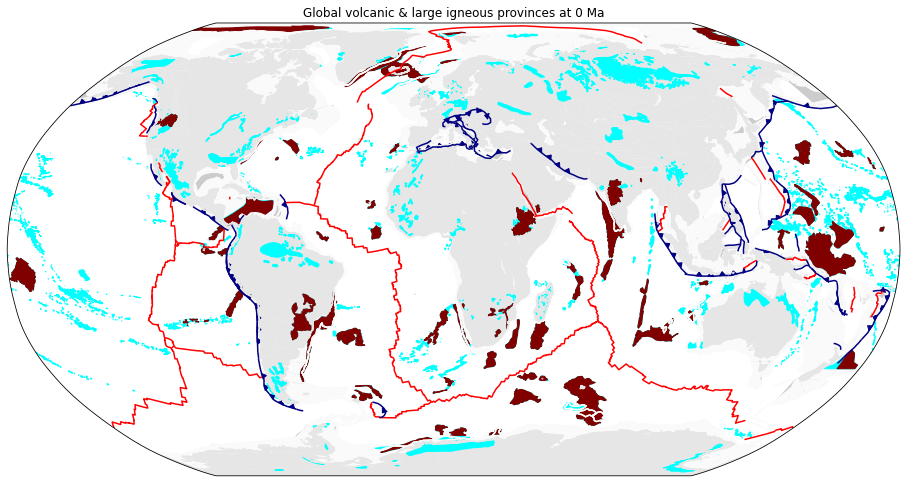

In [9]:
# Set time to present day
time = 0

# Set up GeoAxis and plot shapefile topologies to present day
ax3 = plt.figure(figsize=(16,12)).add_subplot(111, projection=ccrs.Robinson(central_longitude=10))
gplot.time = time
gplot.plot_continents(ax3, facecolor='0.8')
gplot.plot_continent_ocean_boundaries(ax3, color='0.98')
gplot.plot_coastlines(ax3, color='0.9')
gplot.plot_ridges_and_transforms(ax3, color='r')
gplot.plot_trenches(ax3, color='navy')
gplot.plot_subduction_teeth(ax3, color='navy')
plt.title('Global volcanic & large igneous provinces at %i Ma' % (time))

# Loop through all seafloor fabric filenames, reconstruct each topology and plot onto ax2 using GPlately
feat = ["Johansson et al. 2018", "Whittaker et al. 2015"]
colours = ['cyan', 'maroon']
for i, topology in enumerate(lip_volcanic_provinces):
    reconstructed_topology = model.reconstruct(topology, time)
    polygons = gplately.plot.shapelify_feature_polygons(reconstructed_topology)
    ax3.add_geometries(polygons, crs=ccrs.PlateCarree(), facecolor=colours[i], edgecolor=colours[i], label=feat[i])
    ax3.set_global()

### Plotting Shapely Points

Let's visualise present day __surface hotspot/plume locations__ from the "Long-term interaction between mid-ocean ridges and mantle plumes" by Whittaker et al. (2015). These locations are point data split into Pacific and Indo/Atlantic domains. They were compiled from studies by Montelli et al. (2004), Courtillot et al. 2003, Anderson and Schramm (2005) and Steinberger et al. (2000). Any plume points are separated by 500 km or less have been combined into an average point location.

Let's obtain these topology files with GPlately's `DataServer` object and reconstruct these point features to present-day.

In [10]:
# Set reconstruction time to present day
time = 0 # Ma
hotspot_plumes = gdownload.get_feature_data("Hotspots")
        
# Reconstruct hotspot and plume point locations to present day.
reconstructed_hotspot_plumes = model.reconstruct(hotspot_plumes, time)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


Plotting point data requires a matplotlib scatterplot. You'll need two arrays: 1 for the latitudes of the point locations, and 1 for the longitudes of the point locations. We can use pygplates to extract these lat-lon coordinates. Once these arrays are created, we can plot them using "scatter" onto a GeoAxis map! 

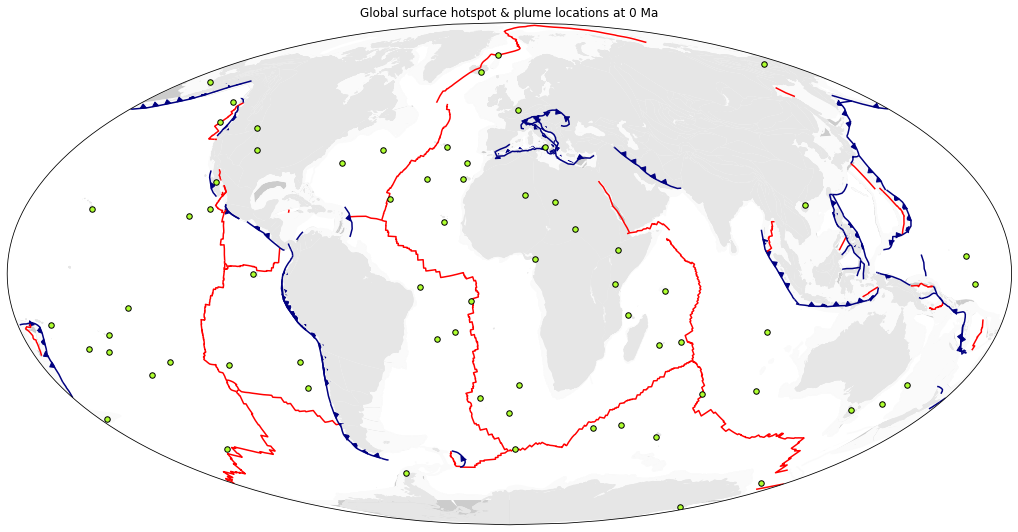

In [11]:
# Extract lat-lon coordinates of point locations
plon = np.zeros(len(reconstructed_hotspot_plumes))
plat = np.zeros(len(reconstructed_hotspot_plumes))
for i, feature in enumerate(reconstructed_hotspot_plumes):
    geometry = feature.get_reconstructed_geometry()
    plat[i], plon[i] = geometry.to_lat_lon()
    
# Set up GeoAxis, plot shapefile topologies and hotspot/plume point features to present day
ax4 = plt.figure(figsize=(18,10)).add_subplot(111, projection=ccrs.Mollweide(central_longitude=0))
gplot.time = time
gplot.plot_continents(ax4, facecolor='0.8')
gplot.plot_continent_ocean_boundaries(ax4, color='0.98')
gplot.plot_coastlines(ax4, color='0.9')
gplot.plot_ridges_and_transforms(ax4, color='r')
gplot.plot_trenches(ax4, color='navy')
gplot.plot_subduction_teeth(ax4, color='navy')
plt.title('Global surface hotspot & plume locations at %i Ma' % (time))
ax4.scatter(plon, plat, transform=ccrs.PlateCarree(), marker='o', color='greenyellow', edgecolor='k', s=30, zorder=2)
ax4.set_global()

### Dataset sources/citations

GPML feature topology data used for this notebook have been sourced from EarthByte's GPlates 2.3 software and dataset database: https://www.earthbyte.org/gplates-2-3-software-and-data-sets/

__Global seafloor fabric:__
- Matthews, K.J., Müller, R.D., Wessel, P. and Whittaker, J.M., 2011. The tectonic fabric of the ocean basins. Journal of Geophysical Research, 116(B12): B12109, DOI: 10.1029/2011JB008413.

__Volcanic provinces:__
- Johansson, L., Zahirovic, S., and Müller, R. D., 2018, The interplay between the eruption and weathering of Large Igneous Provinces and the deep-time carbon cycle: Geophysical Research Letters, doi:10.1029/2017GL076691.
- Bryan, S. E., and Ernst, R. E., 2008, Revised definition of large igneous provinces (LIPs): Earth-Science Reviews, v. 86, no. 1, p. 175-202, doi:10.1016/j.earscirev.2007.08.008.
- Courtillot, V. E., and Renne, P. R., 2003, On the ages of flood basalt events: Comptes Rendus Geoscience, v. 335, no. 1, p. 113-140, doi:10.1016/S1631-0713(03)00006-3.

__Large igneous provinces:__
- Whittaker, J., Afonso, J., Masterton, S., Müller, R., Wessel, P., Williams, S., and Seton, M., 2015, Long-term interaction between mid-ocean ridges and mantle plumes: Nature Geoscience, v. 8, no. 6, p. 479-483, doi: 10.1038/ngeo2437.

__Surface hotspot + plume locations:__
- Whittaker, J., Afonso, J., Masterton, S., Müller, R., Wessel, P., Williams, S., and Seton, M., 2015, Long-term interaction between mid-ocean ridges and mantle plumes: Nature Geoscience, v. 8, no. 6, p. 479-483, doi: 10.1038/ngeo2437.